In [14]:

CURR_PATH = os.path.dirname(os.path.abspath('__file__'))
ROOT =  os.path.join(CURR_PATH, os.pardir, os.pardir)
sys.path.append(os.path.join(ROOT,'modules'))

import my_style as ms
ms.set_style()

ModuleNotFoundError: No module named 'my_style'

In [2]:
import pandas as pd
import numpy as np
import datetime
import os
import xgboost
%matplotlib inline

import matplotlib as mpl

In [3]:
df = pd.read_pickle(os.path.join('data','quote=OMXS30&start=2011-10-10&end=2017-10-09&interval=1440min.pkl'))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 7 columns):
datetime    1485 non-null datetime64[ns]
stock       1485 non-null object
open        1485 non-null float64
high        1485 non-null float64
low         1485 non-null float64
close       1485 non-null float64
volume      1485 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 81.3+ KB


datetime   stock        open        high         low       close  \
0 2011-10-10 22:00:00  OMXS30  925.014320  948.294078  921.049615  948.294078   
1 2011-10-11 22:00:00  OMXS30  947.375798  952.212159  937.354537  946.783556   
2 2011-10-12 22:00:00  OMXS30  943.796878  960.695695  933.507326  957.743383   
3 2011-10-13 22:00:00  OMXS30  954.842203  965.446404  933.353241  936.224381   
4 2011-10-14 22:00:00  OMXS30  940.079858  959.668531  936.803331  956.394709   

   volume  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

open        high         low       close  volume
datetime                                                                   
2011-10-10 22:00:00  925.014320  948.294078  921.049615  948.294078     0.0
2011-10-11 22:00:00  947.375798  952.212159  937.354537  946.783556     0.0
2011-10-12 22:00:00  943.796878  960.695695  933.507326  957.743383     0.0
2011-10-13 22:00:00  954.842203  965.446404  933.353241  936.224381     0.0
2011-10-14 22:00:00  940.079858  959.668531  936.803331  956.394709     0.0

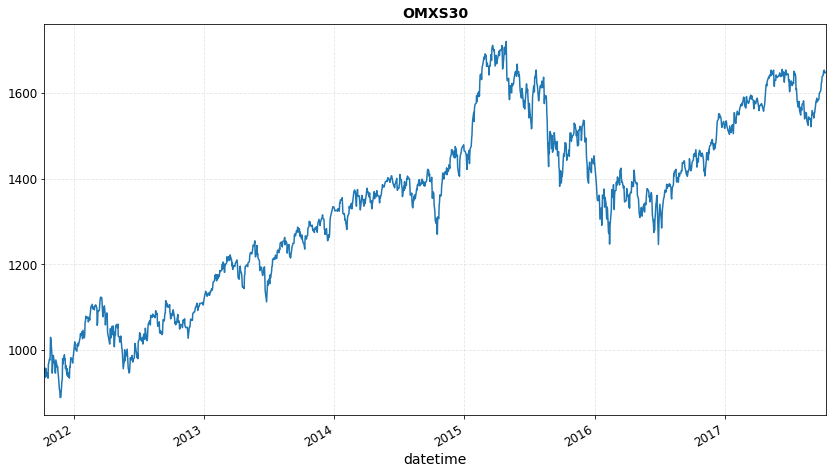

In [4]:
plt.rc('figure', figsize=(14, 8),titlesize=16)

df = df.groupby(['datetime']).sum()
df['close'].plot(grid=True, title = 'OMXS30')
df.head()

In [5]:
# ADD MEASURES

# SHIFT SINGLE
# open/close.shift(1) = GAP
# close/close.shift(1) = GAP + DAY CHANGE (WHAT YOU SEE)
df = df.join(df['open'].div(df['close'].shift(periods=1))
                         .sub(1).mul(100).rename('x_close_open'))

for days in np.arange(1,11):
    # look at at days back total change
    df = df.join(df['open'].div(df['open'].shift(periods=days))
                             .sub(1).mul(100).rename('x_open_open_days_'+str(days)))
    # Look at days back daily change
    df = df.join(df['open'].shift(periods=days-1).div(df['open'].shift(periods=days))
                             .sub(1).mul(100).rename('x_open_open_day_'+str(days)))

for days in np.arange(1,11):
    # look at at days back total change
    df = df.join(df['high'].shift(periods=1).div(df['low'].shift(periods=days))
                             .sub(1).mul(100).rename('x_low_high_days_'+str(days)))
    # Look at days back daily change
    df = df.join(df['high'].shift(periods=days).div(df['low'].shift(periods=days))
                             .sub(1).mul(100).rename('x_low_high_day_'+str(days)))
    
#PREDICTORS, SHIFT BOTH BACK IN TIME, SEE IN FUTURE
#GAP FIRST DAY EXCLUDED SINCE CLOSE PRICE INCLUDED IN X (NO TIME TO TRADE)
# close.shift(-1)/open.shift(1) = NEXT DAY OUTCOME
# close.shift(-days)/open.shift(1) = NEXT X DAYS OUTCOME

df = df.join(df['high'].div(df['low'])
                         .sub(1).mul(100).rename('y_low_high'))
df = df.join(df['high'].div(df['open'])
                         .sub(1).mul(100).rename('y_open_high'))

for days in np.arange(0,11):
    df = df.join(df['close'].shift(periods=-days).div(df['open'])
                             .sub(1).mul(100).rename('y_open_close_days_'+str(days)))
    
df.head()

open        high         low       close  volume  \
datetime                                                                      
2011-10-10 22:00:00  925.014320  948.294078  921.049615  948.294078     0.0   
2011-10-11 22:00:00  947.375798  952.212159  937.354537  946.783556     0.0   
2011-10-12 22:00:00  943.796878  960.695695  933.507326  957.743383     0.0   
2011-10-13 22:00:00  954.842203  965.446404  933.353241  936.224381     0.0   
2011-10-14 22:00:00  940.079858  959.668531  936.803331  956.394709     0.0   

                     x_close_open  x_open_open_days_1  x_open_open_day_1  \
datetime                                                                   
2011-10-10 22:00:00           NaN                 NaN                NaN   
2011-10-11 22:00:00     -0.096835            2.417420           2.417420   
2011-10-12 22:00:00     -0.315455           -0.377772          -0.377772   
2011-10-13 22:00:00     -0.302918            1.170307           1.170307   
2011-10-14 22:00:00      0.411811           -1.546051          -1.546051   

                     x_open_open_days_2  x_open_open_day_2  \
datetime                                                     
2011-10-10 22:00:00                 NaN                NaN   
2011-10-11 22:00:00                 NaN                NaN   
2011-10-12 22:00:00            2.030515           2.417420   
2011-10-13 22:00:00            0.788114          -0.377772   
2011-10-14 22:00:00           -0.393837           1.170307   

                             ...           y_open_close_days_1  \
datetime                     ...                                 
2011-10-10 22:00:00          ...                      2.353394   
2011-10-11 22:00:00          ...                      1.094348   
2011-10-12 22:00:00          ...                     -0.802344   
2011-10-13 22:00:00          ...                      0.162593   
2011-10-14 22:00:00          ...                     -0.072218   

                     y_open_close_days_2  y_open_close_days_3  \
datetime                                                        
2011-10-10 22:00:00             3.538222             1.211880   
2011-10-11 22:00:00            -1.177085             0.951989   
2011-10-12 22:00:00             1.334803            -0.465770   
2011-10-13 22:00:00            -1.617152            -0.975461   
2011-10-14 22:00:00             0.579550             0.227514   

                     y_open_close_days_4  y_open_close_days_5  \
datetime                                                        
2011-10-10 22:00:00             3.392422             1.555288   
2011-10-11 22:00:00            -0.841783            -0.195034   
2011-10-12 22:00:00             0.183431            -0.167219   
2011-10-13 22:00:00            -1.322054            -2.177795   
2011-10-14 22:00:00            -0.641664             2.671764   

                     y_open_close_days_6  y_open_close_days_7  \
datetime                                                        
2011-10-10 22:00:00             2.217671             1.859901   
2011-10-11 22:00:00            -0.544359            -1.406844   
2011-10-12 22:00:00            -1.032974             2.267405   
2011-10-13 22:00:00             1.084407             2.433493   
2011-10-14 22:00:00             4.042035             3.785722   

                     y_open_close_days_8  y_open_close_days_9  \
datetime                                                        
2011-10-10 22:00:00             0.976567             4.343961   
2011-10-11 22:00:00             1.881068             3.240786   
2011-10-12 22:00:00             3.632279             3.376976   
2011-10-13 22:00:00             2.181142             2.957231   
2011-10-14 22:00:00             4.573998             9.495052   

                     y_open_close_days_10  
datetime                                   
2011-10-10 22:00:00              5.736549  
2011-10-11 22:00:00              2.986447  
2011-10-12 22:00:00              4.162147 

In [6]:
# ADD CAT INSTEAD OF FLOAT
df['y_open_close_days_0_up'] = df['y_open_close_days_0']

mask = df['y_open_close_days_0'] < 0
df.loc[df['y_open_close_days_0'][mask].index,'y_open_close_days_0_up'] = 0
mask = df['y_open_close_days_0'] > 0
df.loc[df['y_open_close_days_0'][mask].index,'y_open_close_days_0_up'] = 1
df.head()

open        high         low       close  volume  \
datetime                                                                      
2011-10-10 22:00:00  925.014320  948.294078  921.049615  948.294078     0.0   
2011-10-11 22:00:00  947.375798  952.212159  937.354537  946.783556     0.0   
2011-10-12 22:00:00  943.796878  960.695695  933.507326  957.743383     0.0   
2011-10-13 22:00:00  954.842203  965.446404  933.353241  936.224381     0.0   
2011-10-14 22:00:00  940.079858  959.668531  936.803331  956.394709     0.0   

                     x_close_open  x_open_open_days_1  x_open_open_day_1  \
datetime                                                                   
2011-10-10 22:00:00           NaN                 NaN                NaN   
2011-10-11 22:00:00     -0.096835            2.417420           2.417420   
2011-10-12 22:00:00     -0.315455           -0.377772          -0.377772   
2011-10-13 22:00:00     -0.302918            1.170307           1.170307   
2011-10-14 22:00:00      0.411811           -1.546051          -1.546051   

                     x_open_open_days_2  x_open_open_day_2  \
datetime                                                     
2011-10-10 22:00:00                 NaN                NaN   
2011-10-11 22:00:00                 NaN                NaN   
2011-10-12 22:00:00            2.030515           2.417420   
2011-10-13 22:00:00            0.788114          -0.377772   
2011-10-14 22:00:00           -0.393837           1.170307   

                              ...            y_open_close_days_2  \
datetime                      ...                                  
2011-10-10 22:00:00           ...                       3.538222   
2011-10-11 22:00:00           ...                      -1.177085   
2011-10-12 22:00:00           ...                       1.334803   
2011-10-13 22:00:00           ...                      -1.617152   
2011-10-14 22:00:00           ...                       0.579550   

                     y_open_close_days_3  y_open_close_days_4  \
datetime                                                        
2011-10-10 22:00:00             1.211880             3.392422   
2011-10-11 22:00:00             0.951989            -0.841783   
2011-10-12 22:00:00            -0.465770             0.183431   
2011-10-13 22:00:00            -0.975461            -1.322054   
2011-10-14 22:00:00             0.227514            -0.641664   

                     y_open_close_days_5  y_open_close_days_6  \
datetime                                                        
2011-10-10 22:00:00             1.555288             2.217671   
2011-10-11 22:00:00            -0.195034            -0.544359   
2011-10-12 22:00:00            -0.167219            -1.032974   
2011-10-13 22:00:00            -2.177795             1.084407   
2011-10-14 22:00:00             2.671764             4.042035   

                     y_open_close_days_7  y_open_close_days_8  \
datetime                                                        
2011-10-10 22:00:00             1.859901             0.976567   
2011-10-11 22:00:00            -1.406844             1.881068   
2011-10-12 22:00:00             2.267405             3.632279   
2011-10-13 22:00:00             2.433493             2.181142   
2011-10-14 22:00:00             3.785722             4.573998   

                     y_open_close_days_9  y_open_close_days_10  \
datetime                                                         
2011-10-10 22:00:00             4.343961              5.736549   
2011-10-11 22:00:00             3.240786              2.986447   
2011-10-12 22:00:00             3.376976              4.162147   
2011-10-13 22:00:00             2.957231              7.802203   
2011-10-14 22:00:00             9.495052              9.110203   

                     y_open_close_days_0_up  
datetime                                     
2011-10-10 22:00:00                     1.0  
2011-10-11 22:00:00                     0.0  
2011-10-12 22

In [7]:
# ADD CAT INSTEAD OF FLOAT
df['x_open_open_day_1_up'] = df['x_open_open_day_1']

mask = df['x_open_open_day_1'] < 0
df.loc[df['x_open_open_day_1'][mask].index,'x_open_open_day_1_up'] = False
mask = df['x_open_open_day_1'] > 0
df.loc[df['x_open_open_day_1'][mask].index,'x_open_open_day_1_up'] = True
df.head()

open        high         low       close  volume  \
datetime                                                                      
2011-10-10 22:00:00  925.014320  948.294078  921.049615  948.294078     0.0   
2011-10-11 22:00:00  947.375798  952.212159  937.354537  946.783556     0.0   
2011-10-12 22:00:00  943.796878  960.695695  933.507326  957.743383     0.0   
2011-10-13 22:00:00  954.842203  965.446404  933.353241  936.224381     0.0   
2011-10-14 22:00:00  940.079858  959.668531  936.803331  956.394709     0.0   

                     x_close_open  x_open_open_days_1  x_open_open_day_1  \
datetime                                                                   
2011-10-10 22:00:00           NaN                 NaN                NaN   
2011-10-11 22:00:00     -0.096835            2.417420           2.417420   
2011-10-12 22:00:00     -0.315455           -0.377772          -0.377772   
2011-10-13 22:00:00     -0.302918            1.170307           1.170307   
2011-10-14 22:00:00      0.411811           -1.546051          -1.546051   

                     x_open_open_days_2  x_open_open_day_2  \
datetime                                                     
2011-10-10 22:00:00                 NaN                NaN   
2011-10-11 22:00:00                 NaN                NaN   
2011-10-12 22:00:00            2.030515           2.417420   
2011-10-13 22:00:00            0.788114          -0.377772   
2011-10-14 22:00:00           -0.393837           1.170307   

                             ...           y_open_close_days_3  \
datetime                     ...                                 
2011-10-10 22:00:00          ...                      1.211880   
2011-10-11 22:00:00          ...                      0.951989   
2011-10-12 22:00:00          ...                     -0.465770   
2011-10-13 22:00:00          ...                     -0.975461   
2011-10-14 22:00:00          ...                      0.227514   

                     y_open_close_days_4  y_open_close_days_5  \
datetime                                                        
2011-10-10 22:00:00             3.392422             1.555288   
2011-10-11 22:00:00            -0.841783            -0.195034   
2011-10-12 22:00:00             0.183431            -0.167219   
2011-10-13 22:00:00            -1.322054            -2.177795   
2011-10-14 22:00:00            -0.641664             2.671764   

                     y_open_close_days_6  y_open_close_days_7  \
datetime                                                        
2011-10-10 22:00:00             2.217671             1.859901   
2011-10-11 22:00:00            -0.544359            -1.406844   
2011-10-12 22:00:00            -1.032974             2.267405   
2011-10-13 22:00:00             1.084407             2.433493   
2011-10-14 22:00:00             4.042035             3.785722   

                     y_open_close_days_8  y_open_close_days_9  \
datetime                                                        
2011-10-10 22:00:00             0.976567             4.343961   
2011-10-11 22:00:00             1.881068             3.240786   
2011-10-12 22:00:00             3.632279             3.376976   
2011-10-13 22:00:00             2.181142             2.957231   
2011-10-14 22:00:00             4.573998             9.495052   

                     y_open_close_days_10  y_open_close_days_0_up  \
datetime                                                            
2011-10-10 22:00:00              5.736549                     1.0   
2011-10-11 22:00:00              2.986447                     0.0   
2011-10-12 22:00:00              4.162147                     1.0   
2011-10-13 22:00:00              7.802203                     0.0   
2011-10-14 22:00:00              9.110203                     1.0   

                     x_open_open_day_1_up  
datetime                                   
2011-10-10 22:00:00                   NaN  
2011-10-11 22:00:00                  True  
2011-10-12 22:

In [8]:

df['x_open_open_day_1_streak'] = df['x_open_open_day_1_up']
up_days = 0
down_days = 0

for idx, value in df['x_open_open_day_1_streak'].iteritems():
    if value==False:
        down_days = down_days-1
        up_days = 0
        df.set_value(idx,'x_open_open_day_1_streak',down_days)
    elif value==True:
        up_days = up_days+1
        down_days = 0
        df.set_value(idx,'x_open_open_day_1_streak',up_days)
    else:
        df.set_value(idx,'x_open_open_day_1_streak',0)
        down_days = 0
        up_days = 0

df[['x_open_open_day_1','x_open_open_day_1_streak']].head()

x_open_open_day_1 x_open_open_day_1_streak
datetime                                                       
2011-10-10 22:00:00                NaN                        0
2011-10-11 22:00:00           2.417420                        1
2011-10-12 22:00:00          -0.377772                       -1
2011-10-13 22:00:00           1.170307                        1
2011-10-14 22:00:00          -1.546051                       -1

In [9]:
# Add other measures
df['x_weekday'] = df.index.weekday
df['x_month'] = df.index.month
df['x_year'] = df.index.year
df['x_quarter'] = df.index.quarter
df['x_dayofmonth'] = df.index.day
df[['x_weekday','x_dayofmonth']].head()

x_weekday  x_dayofmonth
datetime                                    
2011-10-10 22:00:00          0            10
2011-10-11 22:00:00          1            11
2011-10-12 22:00:00          2            12
2011-10-13 22:00:00          3            13
2011-10-14 22:00:00          4            14

In [43]:
agg = {'count','mean'}
df[['y_open_close_days_0','x_open_open_day_1_streak']].replace([np.inf,-np.inf],np.nan).dropna().groupby('x_open_open_day_1_streak').agg(agg)

y_open_close_days_0      
                                        mean count
x_open_open_day_1_streak                          
-7                                  0.229347     1
-6                                  0.915621     7
-5                                  0.003921    20
-4                                 -0.195784    33
-3                                  0.179202    73
-2                                  0.048919   167
-1                                  0.019236   382
 0                                  2.516692     1
 1                                 -0.037663   382
 2                                 -0.038574   197
 3                                  0.108786   103
 4                                 -0.057772    59
 5                                  0.170693    28
 6                                  0.030511    17
 7                                  0.089902     6
 8                                 -0.249289     3
 9                                  0.790121     1
 10                                 0.172983     1
 11                                 0.519639     1
 12                                 0.115953     1
 13                                 0.124914     1
 14                                -0.415795     1

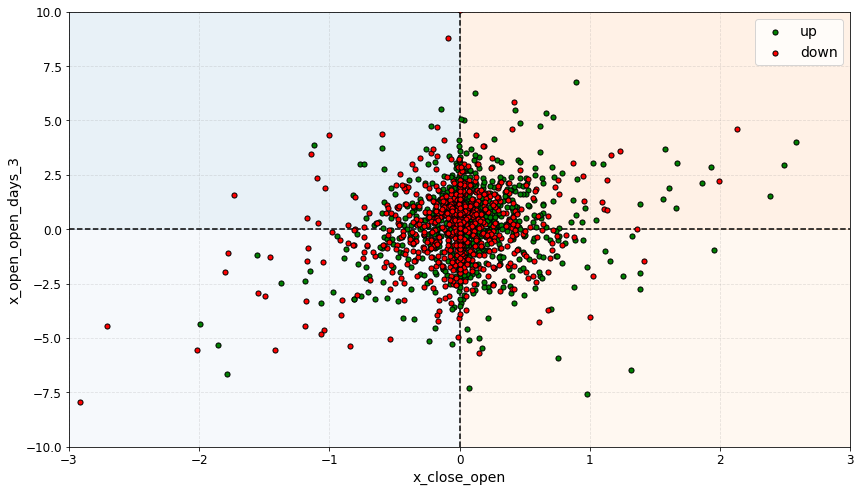

In [153]:
#df_stock_swap = df_stock.swaplevel(axis=1)
import matplotlib.patches as patches
# Close price change dependancy
f, ax = plt.subplots(1,1)
x = 'x_close_open'
y = 'x_open_open_days_3'

    #print('Neg:',df_sel[df_sel[x]<0][y].replace(np.inf,np.nan).dropna().mean())
    #print('Pos:',df_sel[df_sel[x]>0][y].replace(np.inf,np.nan).dropna().mean())
df[df['y_open_close_days_0_up']==1].plot(ax=ax,kind='scatter',x=x,y=y,grid=True,s=26,color='g',edgecolor='black',zorder=3,label='up')
df[df['y_open_close_days_0_up']==0].plot(ax=ax,kind='scatter',x=x,y=y,grid=True,s=26,color='r',edgecolor='black',zorder=3,label='down')
#ax.legend(stocks)
ax.set_title('')
ax.axhline(0,ls = '--',color='black')
ax.axvline(0,ls = '--',color='black')
#ax.set_xlim([-10,10])
#plt.axvline(-1,ls='--',color='r')
#ax.axvspan(xmin=-10,xmax=0,alpha = 0.1,zorder=1)
x_width = 3
y_with = 10
for nr,x,y in zip([0,1,2,3],[-x_width,-x_width,0,0],[0,-y_with,0,-y_with]):
    ax.add_patch(
        patches.Rectangle(
            (x,y),   # (x,y)
            x_width,          # width
            y_with,          # height
            alpha = 0.1,
            color = tableau20[nr]
            ))

#ax.text(-7,7,'Open [-]\nClose [+]\nOverreaction during Pre-Market?')
#ax.text(-7,-7,'Open [-]\nClose [-]\nDecline continues during the day?')
#ax.text(3,7,'Open [+]\nClose [+]\nIncrease continues during the day')
#ax.text(3,-7,'Open [+]\nClose [-]\nGood morning, bad day')
ax.set_xlim([-x_width,x_width])
ax.set_ylim([-y_with,y_with])
f.savefig('fig/dependence.png', dpi=100,bbox_inches='tight')

In [155]:
def set_daily_xticks(df_date,ax,rot=0):
    major_ticks = pd.to_datetime(df_date.index.unique())
    major_tick_labels = list(map(lambda x: x.strftime('%a'), major_ticks))

    minor_ticks = list(filter(lambda x: x.dayofweek == 0, major_ticks))
    minor_tick_labels = list(map(lambda x: x.week, minor_ticks))

    ax.set_xticks(major_ticks, minor=False)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels(major_tick_labels, minor=False, rotation=rot, ha='center',y=-0.03)
    ax.set_xticklabels(minor_tick_labels, minor=True, rotation=0, ha='center', weight='normal',alpha=1)
    
    ax.set_xlabel('')
    ax.grid()
    return ax

In [156]:
def add_measurement(df,x,m,ax,text=False,color='g'):
    y1 = df.loc[x[0]][m[0]]
    y2 = df.loc[x[1]][m[1]]
    if y2 < y1:
        text_color='r'
        color = 'r'
    else:
        text_color='g'
        color = 'g'
    d = {'datetime':x, text:[y1,y2]}
    df = pd.DataFrame(data=d).set_index('datetime')
    df.plot(marker='o', linestyle=':', color=color,ax=ax, legend=False,ms=6,alpha=1,lw=1)
    if text:
        text = str(round((y2/y1-1)*100,1))+'%'
        days = (x[1]-x[0]).days
        x_text = x[1]-pd.DateOffset(days=days/2)
        y_text = (y2+y1)/2
        ax.text(x_text, y_text, text,ha="center", va="center", color=text_color, bbox=dict(facecolor='white',
                                                                                           ec=color,ls=':'))
    return ax

9
datetime
2017-06-21 22:00:00    1647.667755
Name: You, dtype: float64


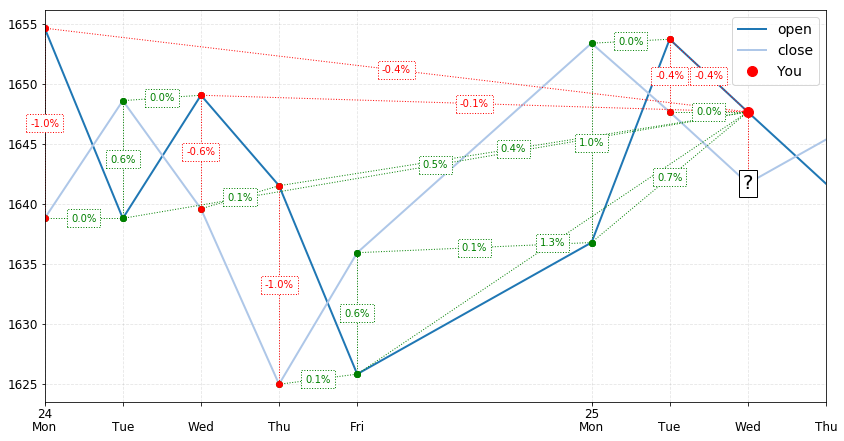

In [174]:
days = 15
start_date = pd.to_datetime('2017-06-10')
df_sel = df[(df.index < start_date+pd.DateOffset(days=days)) &
                       (df.index >= start_date)][['open','close','high','low']]

days = df_sel.shape[0]
print(days)
f, ax = plt.subplots(1,1)
df_sel[['open','close']].plot(lw=2,ax=ax)
d_day = 7
HIST = True
PRED = True
if HIST:
    for i in np.arange(0,d_day):
        x1 = df_sel.index[i]; x2 = df_sel.index[i+1]
        df_sel.pipe(add_measurement,x=[x1,x2],m=['close','open'],ax=ax,color='y',text=True)
        x1 = df_sel.index[i]; x2 = df_sel.index[d_day]
        df_sel.pipe(add_measurement,x=[x1,x2],m=['open','open'],ax=ax,color='y',text=True)
        x1 = df_sel.index[i]; x2 = df_sel.index[i]
        df_sel.pipe(add_measurement,x=[x1,x2],m=['open','close'],ax=ax,color='y',text=True)
if PRED:
    for i in np.arange(d_day,d_day+1):
        x1 = df_sel.index[d_day]; x2 = df_sel.index[i]
        df_sel.pipe(add_measurement,x=[x1,x2],m=['open','close'],ax=ax,color='orange')

# YOU
df_sel.iloc[[d_day]]['open'].rename('You').plot(marker='o', linestyle='none', color='r',ax=ax, legend=True ,
                                                ms=10,alpha=1,lw=1)
# QUESTIONMARK
offset = 0
ax.text(x=df_sel.index[d_day+offset], y=df_sel.loc[df_sel.index[d_day+offset]]['close'], s='?',size=20,ha="center",
        va="center", bbox=dict(facecolor='white',ls='-'))

set_daily_xticks(df_sel,ax)
print(df_sel.iloc[[d_day]]['open'].rename('You'))
f.savefig('fig/all-'+str(days)+'-hist-'+str(HIST)+'-pred-'+str(PRED)+'.png', dpi=100,bbox_inches='tight')

### XGBOOST

In [10]:
df = df.dropna()

x_var = [x for x in np.unique(df.columns) if 'x_' in x]
print(x_var)

df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
train, test = df[df['is_train']==True].copy(), df[df['is_train']==False].copy()
x_train = train[x_var].values
y_train = train['y_open_close_days_0_up'].values
x_test = test[x_var].values
y_test = test['y_open_close_days_0_up'].values

x_combined = np.concatenate((x_train,x_test))
y_combined = np.concatenate((y_train,y_test))

['x_close_open', 'x_dayofmonth', 'x_low_high_day_1', 'x_low_high_day_10', 'x_low_high_day_2', 'x_low_high_day_3', 'x_low_high_day_4', 'x_low_high_day_5', 'x_low_high_day_6', 'x_low_high_day_7', 'x_low_high_day_8', 'x_low_high_day_9', 'x_low_high_days_1', 'x_low_high_days_10', 'x_low_high_days_2', 'x_low_high_days_3', 'x_low_high_days_4', 'x_low_high_days_5', 'x_low_high_days_6', 'x_low_high_days_7', 'x_low_high_days_8', 'x_low_high_days_9', 'x_month', 'x_open_open_day_1', 'x_open_open_day_10', 'x_open_open_day_1_streak', 'x_open_open_day_1_up', 'x_open_open_day_2', 'x_open_open_day_3', 'x_open_open_day_4', 'x_open_open_day_5', 'x_open_open_day_6', 'x_open_open_day_7', 'x_open_open_day_8', 'x_open_open_day_9', 'x_open_open_days_1', 'x_open_open_days_10', 'x_open_open_days_2', 'x_open_open_days_3', 'x_open_open_days_4', 'x_open_open_days_5', 'x_open_open_days_6', 'x_open_open_days_7', 'x_open_open_days_8', 'x_open_open_days_9', 'x_quarter', 'x_weekday', 'x_year']


In [11]:
df_test = pd.DataFrame(y_test,columns=['up_down_days'])
df_test_count = df_test.groupby('up_down_days')['up_down_days'].count()
test_points = df_test_count.sum()
naive_score = df_test_count.loc[1]/test_points
print('naive score:',naive_score)

naive score: 0.531165311653


In [12]:
import xgboost as xgboost

xgb = xgboost.XGBClassifier(max_depth=40,objective='binary:logistic')
xgb.fit(x_train, y_train)
ypred = xgb.predict_proba(x_test)
score = xgb.score(x_test, y_test)

days_gained = (score-naive_score)*test_points
print('Naive Score:',round(naive_score*100,2))
print('Score:',round(score*100,2))
print('Days Tested:',test_points)
print('Days Gained:',int(round(days_gained)))

Naive Score: 53.12
Score: 54.2
Days Tested: 369
Days Gained: 4


In [13]:
# Test only days we predict with certain certainty

check_pred = test.join(pd.DataFrame(ypred,columns=['pred_open_close_down','pred_open_close_up'],index = test.index))

agg = {'y_open_close_days_0':'mean','pred_open_close_down':'count','pred_open_close_up':'count'}
check_pred[check_pred['pred_open_close_up']>0.8][['y_open_close_days_0','y_open_close_days_0_up','pred_open_close_down','pred_open_close_up']].groupby('y_open_close_days_0_up').agg(agg)

y_open_close_days_0  pred_open_close_down  \
y_open_close_days_0_up                                              
0.0                               -0.715792                    28   
1.0                                0.657772                    47   

                        pred_open_close_up  
y_open_close_days_0_up                      
0.0                                     28  
1.0                                     47

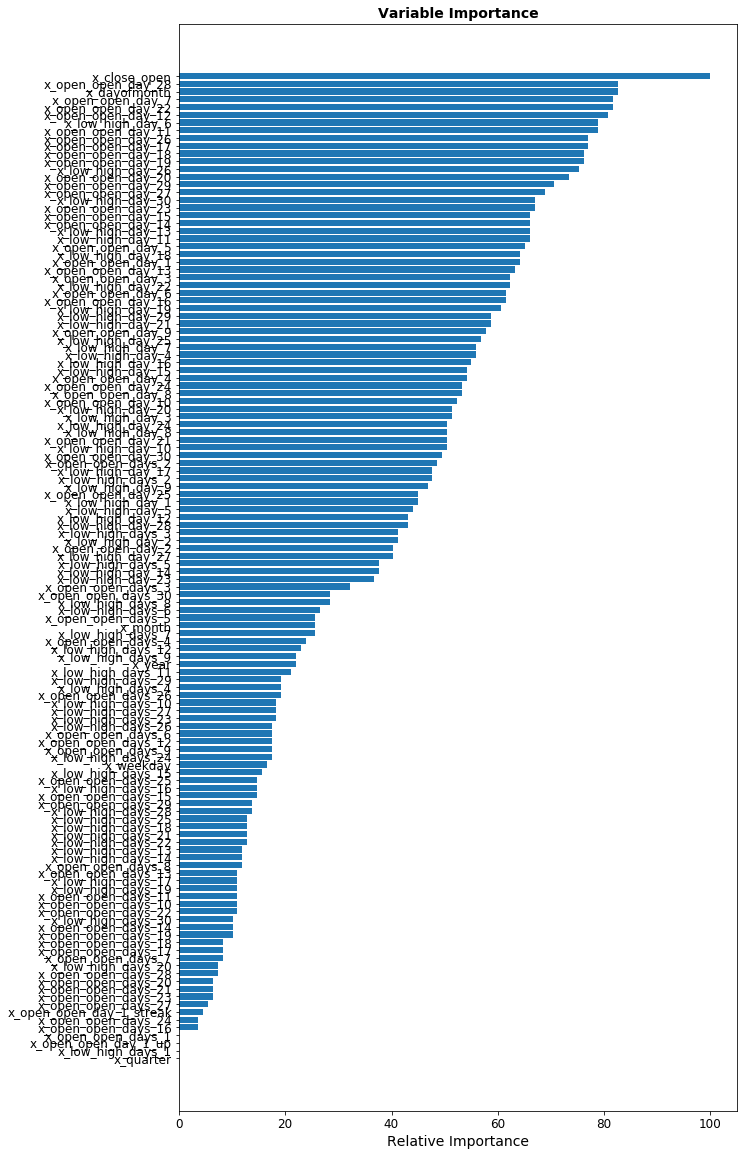

In [57]:
# Plot feature importance
f, ax = plt.subplots(1,1,figsize=(10,20))
feature_importance = xgb.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(x_var)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()